In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

In [2]:
# Physics-Informed Neural Network (PINN) for Heat Equation
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))

In [3]:
# residual function for the PDE
def pde_residual(model, x, t, nu):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]
    return u_t + u * u_x - nu * u_xx


In [4]:
# Training data
N_f, N_u = 1000, 100
x_f = torch.rand(N_f, 1) * 2 - 1
t_f = torch.rand(N_f, 1)
x_u = torch.linspace(-1, 1, N_u).view(-1, 1)
t_u = torch.zeros_like(x_u)
u_u = -torch.sin(np.pi * x_u)

# Model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
nu = 0.01 / np.pi

In [5]:
# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss_f = torch.mean(pde_residual(model, x_f, t_f, nu)**2)
    loss_u = torch.mean((model(x_u, t_u) - u_u)**2)
    loss = loss_f + loss_u
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

Epoch 0, Loss: 0.68310
Epoch 100, Loss: 0.22396
Epoch 200, Loss: 0.14464
Epoch 300, Loss: 0.12865
Epoch 400, Loss: 0.11385
Epoch 500, Loss: 0.10647
Epoch 600, Loss: 0.10202
Epoch 700, Loss: 0.09881
Epoch 800, Loss: 0.09591
Epoch 900, Loss: 0.09344


In [ ]:
# Visualize Setup
x_test = torch.linspace(-1, 1, 200).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
u_pred = model(X.reshape(-1, 1), T.reshape(-1, 1)).detach().numpy().reshape(200, 100)

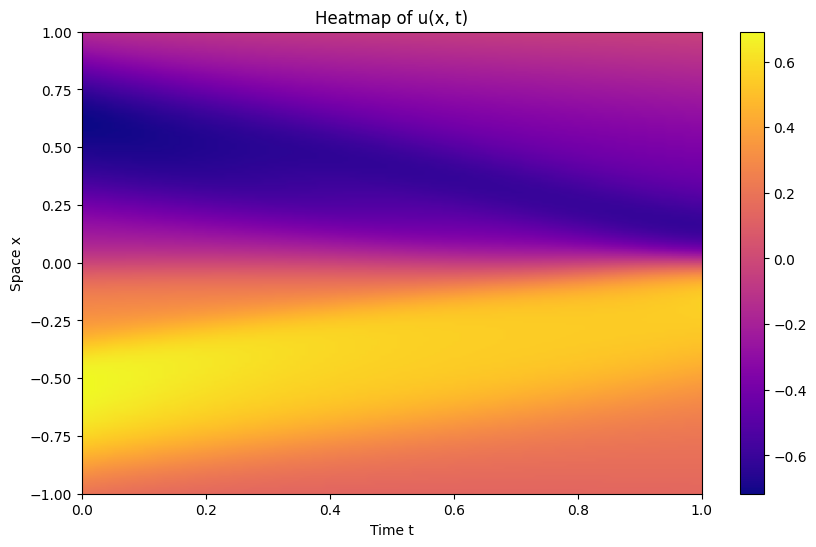

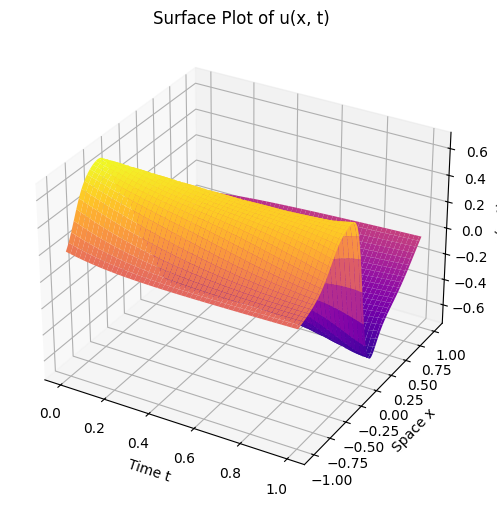

In [7]:
# 1. Heatmap (2D)
plt.figure(figsize=(10, 6))
plt.imshow(u_pred, extent=[0, 1, -1, 1], aspect='auto', origin='lower', cmap='plasma')
plt.colorbar()
plt.xlabel('Time t')
plt.ylabel('Space x')
plt.title('Heatmap of u(x, t)')
plt.show()

# 2. Surface Plot (3D)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X, T = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(0, 1, 100))
ax.plot_surface(T, X, u_pred.T, cmap='plasma', edgecolor='none')
ax.set_xlabel('Time t')
ax.set_ylabel('Space x')
ax.set_zlabel('u(x, t)')
ax.set_title('Surface Plot of u(x, t)')
plt.show()
